In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import cv2
import time
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util

In [2]:
# MODEL_NAME = 'trained-inference-graphs-fasterRCNN'
MODEL_FILE = 'frozen_inference_graph.pb'
PATH_TO_LABELS = 'label_map.pbtxt'
# PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(MODEL_FILE, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
images=[]
PATH_TO_TEST_IMAGES_DIR = 'images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'test_shot{}.jpeg'.format(i)) for i in range(16, 17) ]
images.append(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (8, 5)

In [7]:
def run_inference_for_multiple_images(images, graph):
    with graph.as_default():
        with tf.Session() as sess:
            output_dict_array = []
            dict_time = []
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, images[0].shape[0], images[0].shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            for image in images:
                # Run inference
                start = time.time()
                output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
                end = time.time()
                print('inference time : {}'.format(end - start))
 
                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]
 
                output_dict_array.append(output_dict)
                dict_time.append(end - start)
    return output_dict_array, dict_time

In [8]:
images=[]
for image_path in TEST_IMAGE_PATHS:

    image = cv2.imread(image_path)
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image_np)

In [9]:
# detection - this cell will take a bit to run (up to 5 mins) because the detection is not running on GPU
output_dicts, out_time = run_inference_for_multiple_images(images, detection_graph)

inference time : 10.224833250045776


In [10]:
# output_dicts

In [11]:
##### KEEP THIS IMPORTS HERE OTHERWISE THE NEXT CELL WON'T RUN PROPERLY #####

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt

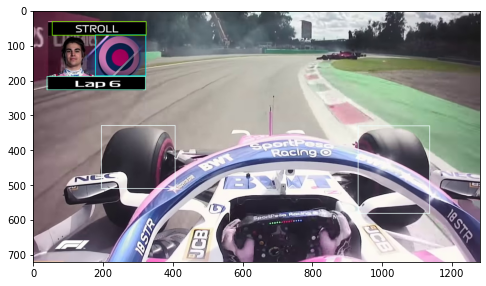

In [12]:
images=[]
count = 0
for image_path in TEST_IMAGE_PATHS:

    image = cv2.imread(image_path)
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #images.append(image_np)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dicts[count]['detection_boxes'],
              output_dicts[count]['detection_classes'],
              output_dicts[count]['detection_scores'],
              category_index,
              instance_masks=output_dicts[count].get('detection_masks'),
              use_normalized_coordinates=True,
              skip_labels=True,
              skip_scores=True,
              min_score_thresh=0.75,
              line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
    count+=1
    

In [13]:
# specifying shaoe of the numoy array so that lables will be cropped out based on coordinates
img_height, img_width, img_channel, = image_np.shape

In [14]:
# assigning coordinates to all the bounding boxes detected
absolute_coord = []
THRESHOLD = 0.7
N = len(output_dicts[0]["detection_boxes"])
for i in range(N):
    if output_dicts[0]['detection_scores'][i] < THRESHOLD:
        continue
    box = output_dicts[0]['detection_boxes'][i]
    ymin, xmin, ymax, xmax = box
    ymin = int(ymin*img_height)
    ymax = int(ymax*img_height)
    xmin = int(xmin*img_width)
    xmax = int(xmax*img_width)
    absolute_coord.append((xmin,ymin,xmax,ymax))

In [15]:
label_class = []

THRESHOLD = 0.7
N = len(output_dicts[0]["detection_boxes"])
for i in range(N):
    if output_dicts[0]['detection_scores'][i] < THRESHOLD:
        continue
    label = output_dicts[0]['detection_classes'][i]
    label_class.append(label)
    
label_class

[2, 3, 4, 1, 4]

In [16]:
# assigning string value to label in label_class
label_class_str = [str(i) for i in label_class]
labels = [label.replace('1', 'driver').replace('2', 'team').replace('3', 'lap').replace('4', 'soft').replace('5', 'medium').replace('6', 'hard').replace('7', 'inter') for label in label_class_str]
labels

['team', 'lap', 'soft', 'driver', 'soft']

In [17]:
bounding_box_img = []
for c in absolute_coord:
    bounding_box_img.append(image_np[c[1]:c[3],c[0]:c[2],:])

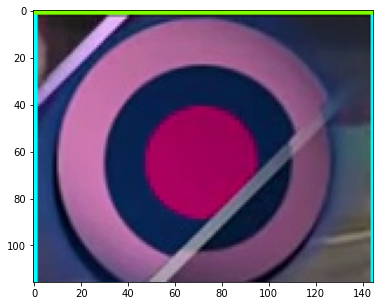

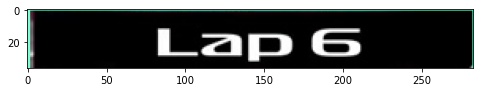

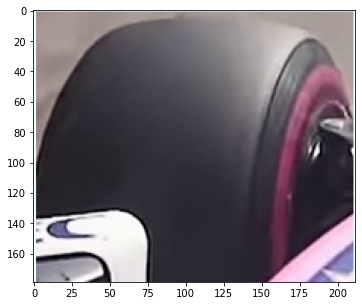

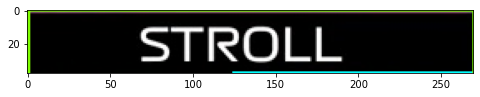

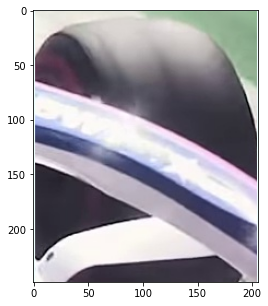

In [18]:
#display crops
for i in range(len(bounding_box_img)):
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(bounding_box_img[i])
    plt.imsave
    plt.show()